In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime
from dateutil.relativedelta import relativedelta
from prophet import Prophet


In [4]:
final_df = pd.read_csv('../data/processed/train_data.csv')
final_df.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,O00391,O00533,O00584,O14498,...,YSLTYIYTGLSK_P25311,YTTEIIK_P00736,YVGGQEHFAHLLILR_P02763,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR_P00738,YVMLPVADQDQC(UniMod_4)IR_P00738,YVNKEIQNAVNGVK_P10909,YWGVASFLQK_P02753,YYC(UniMod_4)FQGNQFLR_P02790,YYTYLIMNK_P01024,YYWGGQYTWDMAK_P02675
0,37312_36,37312.0,36.0,5.0,15.0,43.0,13216.9,746572.0,20555.8,37357.9,...,139521.0,14420.90,286421.0,0.0,0.0,54514.5,92394.7,306225.0,28934.9,8098.97
1,40876_60,40876.0,60.0,14.0,20.0,37.0,0.0,219777.0,14475.5,14013.1,...,262055.0,0.00,4441850.0,32089.4,365434.0,85944.1,49694.7,370810.0,41173.2,28514.60
2,15590_24,15590.0,24.0,15.0,0.0,2.0,0.0,398463.0,25800.7,0.0,...,207074.0,6913.96,2561520.0,253017.0,1257160.0,91574.7,84548.8,414032.0,41104.9,27716.30
3,57321_0,57321.0,0.0,12.0,4.0,17.0,10128.7,401709.0,32738.2,30719.7,...,256817.0,0.00,2466490.0,0.0,376286.0,85551.3,152759.0,434899.0,0.0,5469.76
4,45161_60,45161.0,60.0,17.0,7.0,15.0,0.0,452096.0,12303.0,29160.0,...,272789.0,9581.34,4289800.0,39040.0,335913.0,89818.3,114909.0,367032.0,47512.4,34067.70


In [5]:
final_df['visit_month'].unique()

array([ 36.,  60.,  24.,   0.,  48.,  12.,   6.,  72.,  84.,  18.,  96.,
        54.,   3.,  30., 108.])

### Fill in the monthly data between months using linear steps between the two values

In [6]:

def fill_missing_months(df):
    # Create an empty dataframe with the same columns as the original dataframe
    filled_df = pd.DataFrame(columns=df.columns)
    
    # Iterate over the unique patient_ids in the dataframe
    for id in df['patient_id'].unique():
        # Create a new dataframe for this patient_id that is sorted by 'visit_month'
        test_df = df[df['patient_id'] == id]
        test_df = test_df.sort_values(by='visit_month')
        
        # Create a new column in the new dataframe that is the difference between the next
        # 'visit_month' and the current 'visit_month'
        test_df['visit_month_diff'] = test_df['visit_month'].shift(-1)  - test_df['visit_month']
        
        # Create a new dataframe that contains all of the months between the minimum and
        # maximum 'visit_month' for the patient_id
        date_range = range(int(test_df['visit_month'].min()), int(test_df['visit_month'].max() + 1))
        date_df = pd.DataFrame([x for x in date_range], columns=['visit_month_fill'])
        
        # Merge the new dataframe with the original dataframe.  This will create a new dataframe
        # that has the same number of rows as the new dataframe with all of the months.  Each row
        # will contain the original values for that month if they exist, or null values otherwise.
        to_fill_date = date_df.merge(test_df, how='left', left_on='visit_month_fill', right_on='visit_month')
        
        # Fill in the missing patient_id and visit_id values with the previous value
        to_fill_date[['patient_id', 'visit_id']] = to_fill_date[['patient_id', 'visit_id']].fillna(method='ffill')
        
        # Use linear interpolation to fill in the missing values of the original columns
        test_fill_date = to_fill_date.interpolate(method='linear')
        
        # Drop the columns we created for this function
        test_fill_date = test_fill_date.drop(['visit_month_fill', 'visit_month_diff'], axis=1)
        
        # Concatenate the new dataframe to the output dataframe
        filled_df = pd.concat([filled_df, test_fill_date])

    return filled_df
    
    


In [7]:
filled_final_df = fill_missing_months(final_df)

In [11]:
timestamp = datetime.datetime(2020, 1, 1)
filled_final_df['ds'] = filled_final_df['visit_month'].apply(lambda x: timestamp + relativedelta(months=(x-1)))

In [12]:
test_patient = filled_final_df['patient_id'].unique()[0]

21:15:16 - cmdstanpy - INFO - Chain [1] start processing
21:15:40 - cmdstanpy - INFO - Chain [1] done processing


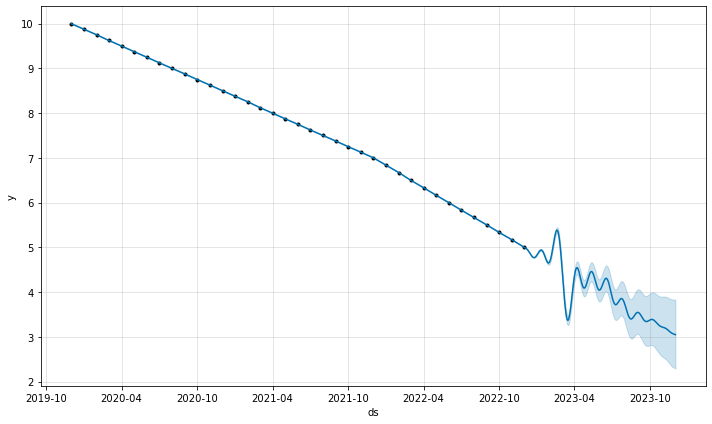

In [16]:
# Define the target variable
filled_final_df.rename(columns={'updrs_1': 'y'}, inplace=True)

# Create a model instance
m = Prophet()

# create a test dataframe with test_patient
test_df = filled_final_df[filled_final_df['patient_id'] == test_patient]

# Fit the model
m.fit(test_df[['y', 'ds']])

# Create a future dataframe
future = m.make_future_dataframe(periods=365)


# Make predictions
forecast = m.predict(future)

# Plot the forecast
fig = m.plot(forecast)
